In [4]:
%config InlineBackend.figure_format = 'retina'

import utils
import pymc as pm
import aesara.tensor as at
import arviz as az
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, auc
)

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])

# 15M2

In [2]:
df = pd.read_csv("data/milk.csv", sep=";")
df['neocortex.prop'] = df['neocortex.perc'] / 100
df['logmass'] = np.log(df.mass)

K = StandardScaler().fit_transform(df['kcal.per.g'].values.reshape(-1, 1)).reshape(-1)
B = StandardScaler().fit_transform(df['neocortex.prop'].values.reshape(-1, 1)).reshape(-1)
M = StandardScaler().fit_transform(df['logmass'].values.reshape(-1, 1)).reshape(-1)

In [3]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", lam=1)
    sigma_B = pm.Exponential("sigma_B", lam=1)

    alpha = pm.Normal("alpha", mu=0, sigma=1)
    nu = pm.Normal("nu", mu=0, sigma=1)

    bM = pm.Normal("bM", mu=0, sigma=1)
    bB = pm.Normal("bB", mu=0, sigma=1)

    B_imp = pm.Normal("B", mu=nu, sigma=sigma_B, observed=B)

    mu = pm.Deterministic("mu", alpha + bB * B_imp + bM * M)
    pm.Normal("K", mu=mu, sigma=sigma, observed=K)

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/pymc/model.py:1431: ImputationWarning: Data in B contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [4]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, sigma_B, alpha, nu, bM, bB, B_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


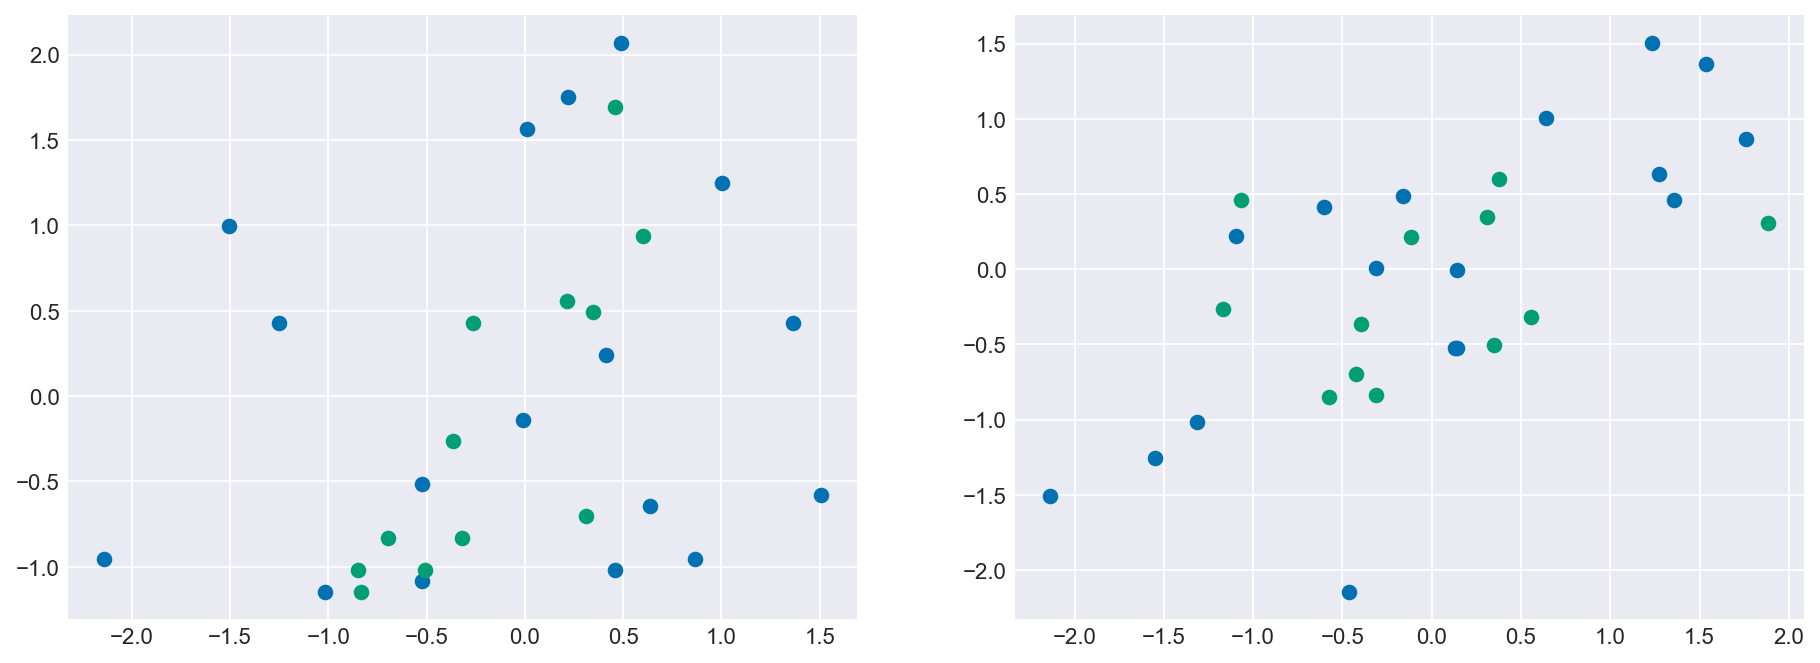

In [5]:
B_imp = trace["posterior"]["B_missing"].mean(axis=(0, 1))
K_imp = K[np.isnan(B)]
M_imp = M[np.isnan(B)]
plt.figure(figsize=(14, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(B, K)
plt.scatter(B_imp, K_imp, marker="o")

plt.subplot(1, 2, 2)
plt.scatter(M, B)
plt.scatter(M_imp, B_imp, marker="o")

# 15M3

In [6]:
K = StandardScaler().fit_transform(df['kcal.per.g'].values.reshape(-1, 1)).reshape(-1)
B = MinMaxScaler(feature_range=(0.05, 0.95)).fit_transform(df['neocortex.prop'].values.reshape(-1, 1)).reshape(-1)
M = StandardScaler().fit_transform(df['logmass'].values.reshape(-1, 1)).reshape(-1)

In [7]:
with pm.Model() as model2:
    sigma = pm.Exponential("sigma", lam=1)
    sigma_B = pm.Exponential("sigma_B", lam=1)

    alpha = pm.Normal("alpha", mu=0, sigma=1)
    nu = pm.Normal("nu", mu=0, sigma=1)

    bM = pm.Normal("bM", mu=0, sigma=1)
    bB = pm.Normal("bB", mu=0, sigma=1)

    B_imp = pm.Beta("B", alpha=1, beta=1, observed=B)

    mu = pm.Deterministic("mu", alpha + bB * B_imp + bM * M)
    pm.Normal("K", mu=mu, sigma=sigma, observed=K)

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/pymc/model.py:1431: ImputationWarning: Data in B contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [8]:
with model2:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, sigma_B, alpha, nu, bM, bB, B_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.620,0.429,-1.451,0.173,0.011,0.008,1551.0,1589.0,1.0
nu,-0.017,1.026,-2.004,1.817,0.016,0.019,4189.0,2749.0,1.0
bM,-0.475,0.199,-0.848,-0.109,0.004,0.003,2288.0,1810.0,1.0
bB,1.173,0.745,-0.229,2.541,0.020,0.015,1440.0,1510.0,1.0
sigma,0.896,0.155,0.635,1.197,0.003,0.002,1838.0,1389.0,1.0
sigma_B,1.011,1.002,0.000,2.749,0.014,0.011,2760.0,1445.0,1.0
B_missing[0],0.389,0.272,0.000,0.864,0.004,0.003,3921.0,2281.0,1.0
B_missing[1],0.362,0.268,0.000,0.861,0.005,0.004,2869.0,1340.0,1.0
B_missing[2],0.360,0.266,0.000,0.862,0.004,0.004,4295.0,2337.0,1.0
B_missing[3],0.447,0.275,0.003,0.906,0.004,0.003,4779.0,2324.0,1.0


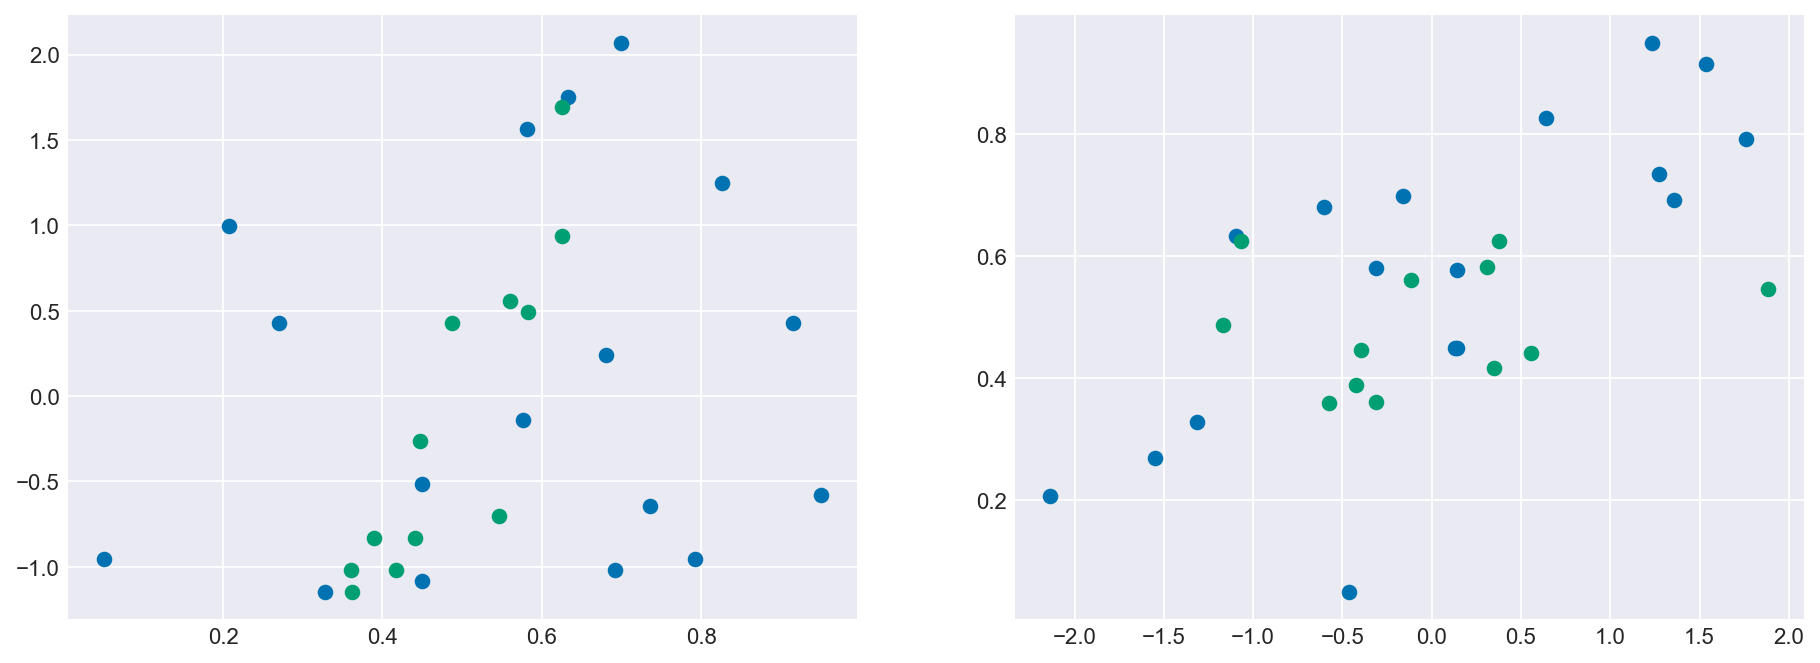

In [10]:
B_imp = trace["posterior"]["B_missing"].mean(axis=(0, 1))
K_imp = K[np.isnan(B)]
M_imp = M[np.isnan(B)]
plt.figure(figsize=(14, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.scatter(B, K)
plt.scatter(B_imp, K_imp, marker="o")

plt.subplot(1, 2, 2)
plt.scatter(M, B)
plt.scatter(M_imp, B_imp, marker="o")

# 15M4

In [276]:
df = pd.read_csv("data/marriage.csv", sep=";")

In [277]:
D_obs = StandardScaler().fit_transform(df.Divorce.values.reshape(-1, 1)).reshape(-1)
D_sd = df["Divorce SE"] / np.std(df["Divorce"])
M = StandardScaler().fit_transform(df.Marriage.values.reshape(-1, 1)).reshape(-1)
A = StandardScaler().fit_transform(df.MedianAgeMarriage.values.reshape(-1, 1)).reshape(-1)
N = len(df)

In [278]:
with pm.Model() as model3:
    sigma = pm.Exponential("sigma", lam=1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * A + bM * M)

    d_true = pm.Normal("d_true", mu=mu, sigma=sigma)
    d_obs = pm.Normal("d_obs", mu=d_true, sigma=D_sd, observed=D_obs)

    trace3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, d_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [15]:
az.summary(trace3, var_names=["a", "bA", "bM", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.055,0.096,-0.236,0.123,0.002,0.001,3744.0,3090.0,1.0
bA,-0.614,0.161,-0.911,-0.310,0.003,0.002,2747.0,3038.0,1.0
bM,0.054,0.168,-0.268,0.363,0.003,0.003,2443.0,2779.0,1.0
sigma,0.596,0.107,0.402,0.794,0.003,0.002,946.0,1629.0,1.0


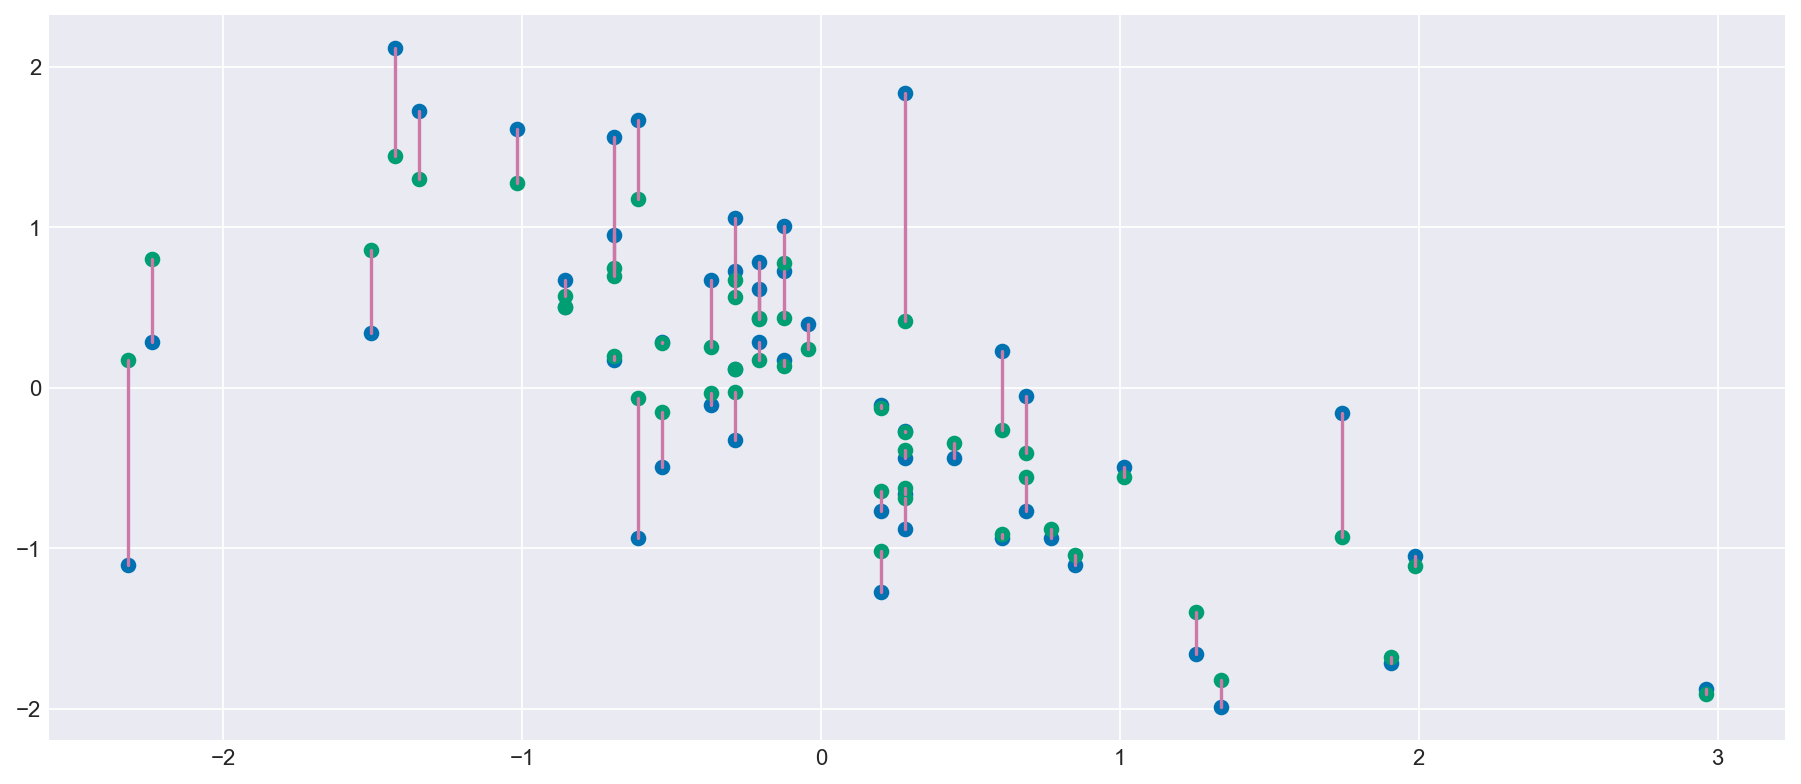

In [16]:
plt.figure(figsize=(14,6), dpi=80)

d_true = trace3["posterior"]["d_true"].mean(axis=(0,1)).values.reshape(-1)
plt.scatter(A, D_obs)
plt.scatter(A, d_true)

for a,b,c in zip(A, D_obs, d_true):
    plt.plot([a, a], [b, c], c="C3")

# 15M4

In [17]:
N = 100
X = np.random.normal(0, 1, size=N)
Y = np.random.normal(X, 1, size=N)
Z = np.random.normal(Y, 1, size=N)

In [18]:
with pm.Model() as model4:
    sigma = pm.Exponential("sigma", lam=1)
    a = pm.Normal("a", 0, 1)
    bX = pm.Normal("bX", 0, 1)
    bZ = pm.Normal("bZ", 0, 1)

    mu = pm.Deterministic("mu", a + bX * X + bZ * Z)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=Y)

    trace4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bX, bZ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [19]:
# post treatment bias
az.summary(trace4, var_names=["a", "bX", "bZ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.040,0.068,-0.173,0.084,0.001,0.001,3694.0,2744.0,1.0
bX,0.688,0.079,0.539,0.833,0.001,0.001,3114.0,2761.0,1.0
bZ,0.379,0.050,0.285,0.473,0.001,0.001,3001.0,2914.0,1.0


# 15M5

In [20]:
np.random.seed(45)
N = 100
alpha = 5
beta = -3
k = 0.5 # probability of cat
r = 0.2 # probability of not knowing cat

real_cat = cat = np.random.binomial(n=1, p=k, size=N)
notes = np.random.poisson(lam=alpha + beta*cat, size=N)
R_C = np.random.binomial(n=1, p=r, size=N)
cat_obs = cat.astype(float)
cat_obs[R_C == 1] = float("nan")

# full case, drop missingness
# notes = notes[R_C == 0]
# cat_obs = cat = cat[R_C == 0]

# as in the book
cat = cat_obs
RC = R_C


In [21]:
with pm.Model() as m15_8:
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.5)
    _k = pm.Beta("k", 2, 2)

    custom_logp = pm.math.logsumexp(
        pm.math.log(_k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes[R_C==1])
        + pm.math.log(1 - _k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes[R_C==1])
    )

    _notes1 = pm.Potential("notes|RC=1", custom_logp)

    cat_rc_0 = pm.Bernoulli("cat|RC=0", p=_k, observed=cat[R_C==0])
    lam_0 = at.exp(a + b * cat_rc_0)
    _notes0 = pm.Poisson("notes|RC=0", mu=lam_0, observed=notes[R_C == 0])
    
    trace5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [22]:
az.summary(trace5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.590,0.066,1.481,1.689,0.001,0.001,2933.0,2808.0,1.0
b,-0.767,0.121,-0.954,-0.571,0.002,0.002,2864.0,3127.0,1.0
k,0.454,0.052,0.366,0.531,0.001,0.001,3812.0,2840.0,1.0


In [23]:
with pm.Model() as m15_9:
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.5)
    _k = pm.Beta("k", 2, 2)

    custom_logp = pm.math.logsumexp(
        pm.math.log(_k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes[R_C==1])
        + pm.math.log(1 - _k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes[R_C==1])
    )

    _notes1 = pm.Potential("notes|RC=1", custom_logp)

    cat_rc_0 = pm.Bernoulli("cat|RC=0", p=_k, observed=cat[R_C == 0])
    lam_0 = at.exp(a + b * cat_rc_0)
    _notes0 = pm.Poisson("notes|RC=0", mu=lam_0, observed=notes[R_C == 0])

    # cat_rc_0 = pm.Bernoulli("cat|RC=0", p=_k, observed=cat)
    # lam_0 = at.exp(a + b * cat_rc_0)
    # _notes0 = pm.Poisson("notes|RC=0", mu=lam_0, observed=notes)

    lpC0 = pm.math.log(1-_k) + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes)
    lpC1 = pm.math.log(_k) + pm.logp(pm.Poisson.dist(pm.math.exp(a+b)), notes)
    PrC1 = pm.Deterministic("PrC1", pm.math.exp(lpC1) / (pm.math.exp(lpC1) + pm.math.exp(lpC0)))
    
    trace15_9 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [24]:
az.summary(trace15_9, var_names=["a", "b", "k"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.593,0.064,1.474,1.715,0.001,0.001,3355.0,2994.0,1.0
b,-0.771,0.120,-1.001,-0.552,0.002,0.001,3418.0,2799.0,1.0
k,0.456,0.053,0.354,0.556,0.001,0.001,4431.0,2696.0,1.0


In [25]:
x = np.concatenate([
    real_cat.reshape(-1, 1),
    trace15_9.posterior["PrC1"].values.mean(axis=(0, 1)).reshape(-1, 1)
], axis=1)
x = np.concatenate([x, (x[:, 1] > 0.5).reshape(-1, 1), np.zeros((len(cat), 1))], axis=1)

array([[38, 16],
       [ 7, 39]])

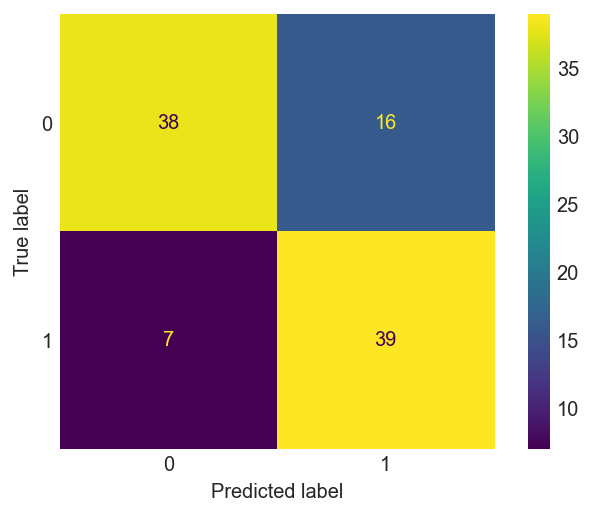

In [26]:
df = pd.DataFrame(x, columns=["y_true", "prob_cat", "y_pred", "absence"])
cm = confusion_matrix(df.y_true, df.y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid(False)
cm

# 15M6

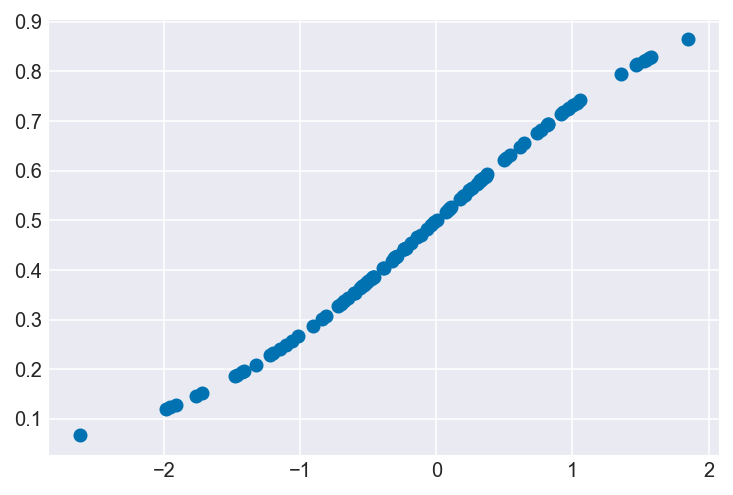

In [27]:
N = 100
np.random.seed(42)
S = np.random.normal(0, 1, size=N)
p = utils.sigmoid(S)
H = np.random.binomial(n=10, p=utils.sigmoid(S), size=N).astype(float)

plt.scatter(S, p)

## Scenario 1
 Dogs eat homeworks at random

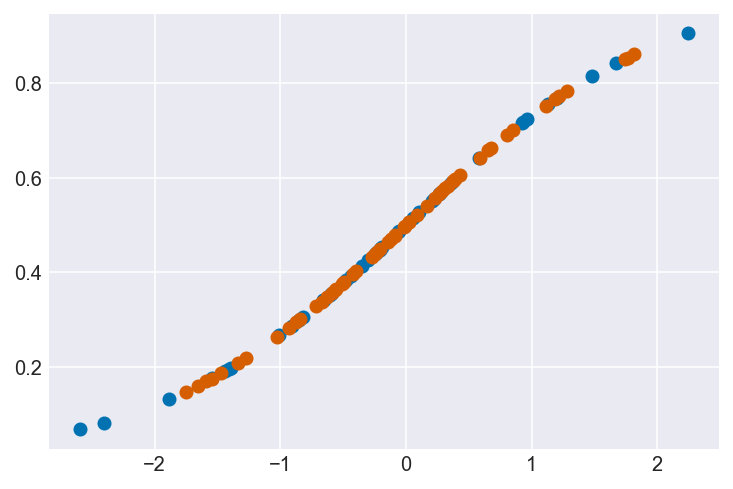

In [28]:
k = 0.5
np.random.seed(45)
S = np.random.normal(0, 1, size=N)
p = utils.sigmoid(S)
H = np.random.binomial(n=10, p=p, size=N).astype(float)
eat = np.random.binomial(n=1, p=k, size=N)

H[eat == 1] = float("nan")

plt.scatter(S[eat != 1], p[eat != 1])
plt.scatter(S[eat == 1], p[eat == 1], c="C2")

In [29]:
with pm.Model() as model1:
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=1, sigma=.5)
    p = pm.Deterministic("p", at.sigmoid(a + b * S))

    h = pm.Binomial("h", n=10, p=p, observed=H)
    trace1 = pm.sample()
    
az.summary(trace1, var_names=["a", "b"])

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/pymc/model.py:1431: ImputationWarning: Data in h contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, b]
>Metropolis: [h_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.120,0.112,-0.338,0.081,0.007,0.005,253.0,798.0,1.02
b,0.879,0.130,0.638,1.122,0.008,0.005,290.0,865.0,1.02


## Scenario 2

Dog eats homeworks if studient study too much

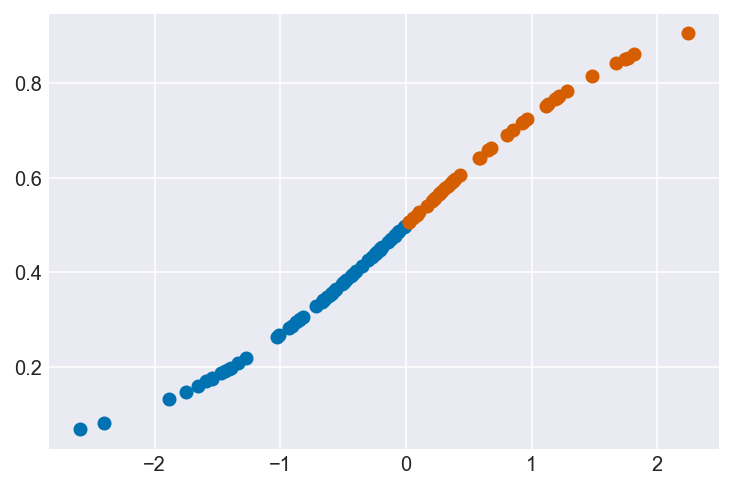

In [30]:
np.random.seed(45)
S = np.random.normal(0, 1, size=N)
p = utils.sigmoid(S)
H = np.random.binomial(n=10, p=p, size=N).astype(float)
eat = (S > 0).astype(int)

H[eat == 1] = float("nan")

plt.scatter(S[eat != 1], p[eat != 1])
plt.scatter(S[eat == 1], p[eat == 1], c="C2")

In [31]:
with pm.Model() as model2:
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=1, sigma=.5)
    p = pm.Deterministic("p", at.sigmoid(a + b * S))

    h = pm.Binomial("h", n=10, p=p, observed=H)
    trace2 = pm.sample()
    
az.summary(trace2, var_names=["a", "b"])

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/pymc/model.py:1431: ImputationWarning: Data in h contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, b]
>Metropolis: [h_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.024,0.139,-0.302,0.221,0.011,0.008,155.0,305.0,1.02
b,0.948,0.166,0.634,1.260,0.013,0.009,163.0,273.0,1.01


## Scenario 3

Dog eats homeworks if noise home, student have worse results if noise home

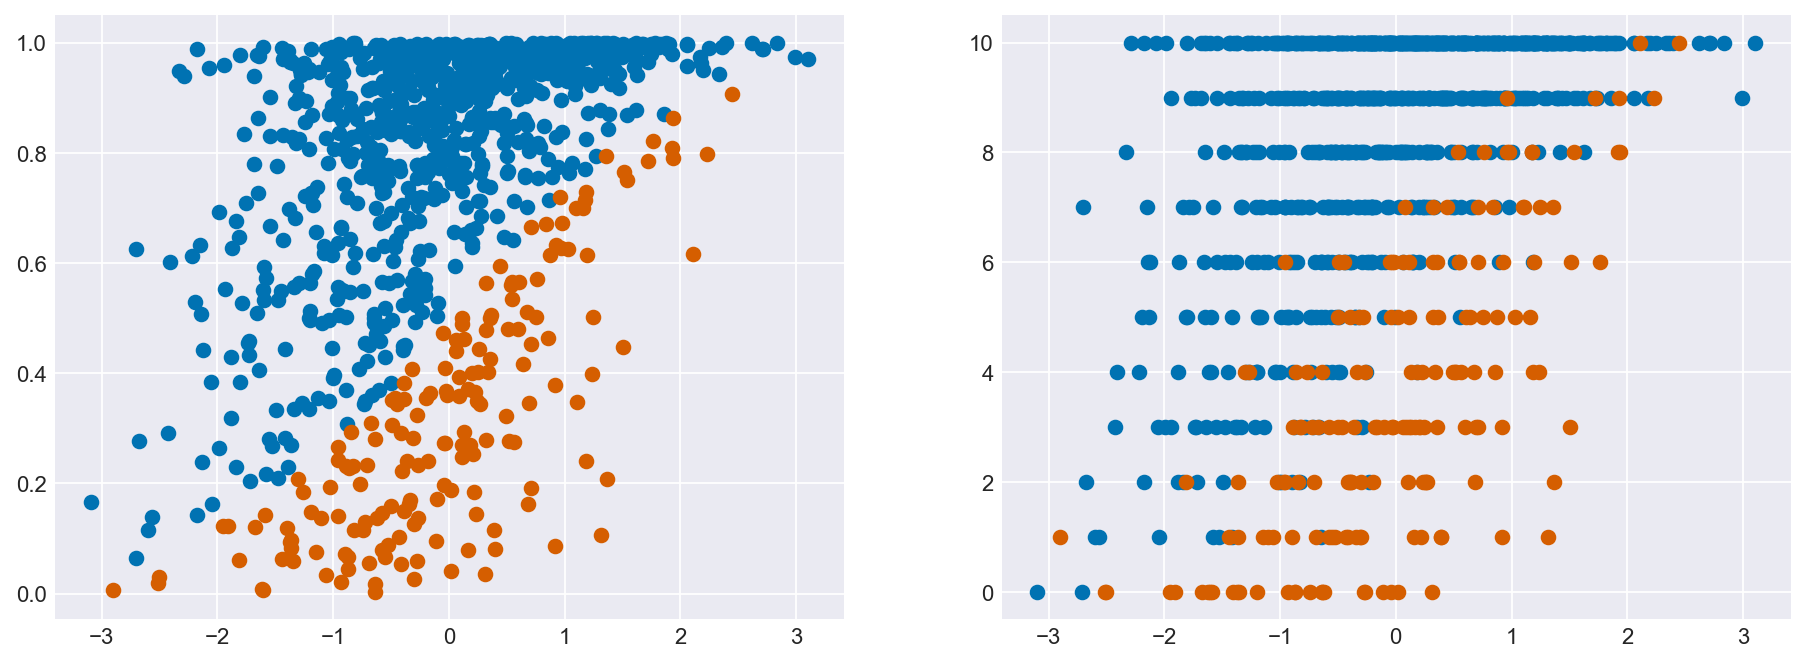

In [32]:
np.random.seed(45)
N = 1000
S = np.random.normal(0, 1, size=N)
X = np.random.normal(size=N)
p = utils.sigmoid(2+S - 2*X)
H = np.random.binomial(n=10, p=p, size=N).astype(float)
eat = (X > 1).astype(int)

raw_h = H.copy()
H[eat == 1] = float("nan")

plt.figure(figsize=(14,5), dpi=80)
plt.subplot(1,2,1)
plt.scatter(S[eat != 1], p[eat != 1])
plt.scatter(S[eat == 1], p[eat == 1], c="C2")
plt.subplot(1, 2, 2)
plt.scatter(S[eat != 1], raw_h[eat != 1])
plt.scatter(S[eat == 1], raw_h[eat == 1], c="C2")

In [33]:
with pm.Model() as model3_1:
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    p = pm.Deterministic("p", at.sigmoid(a + b * S[eat == 0]))

    h = pm.Binomial("h", n=10, p=p, observed=H[eat == 0])
    trace3 = pm.sample()
    
az.summary(trace3, var_names=["a", "b"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.983,0.039,1.911,2.055,0.001,0.001,2248.0,2310.0,1.0
b,0.958,0.037,0.890,1.029,0.001,0.001,2349.0,2430.0,1.0


## Scenario 4

Dog eats add homeworks

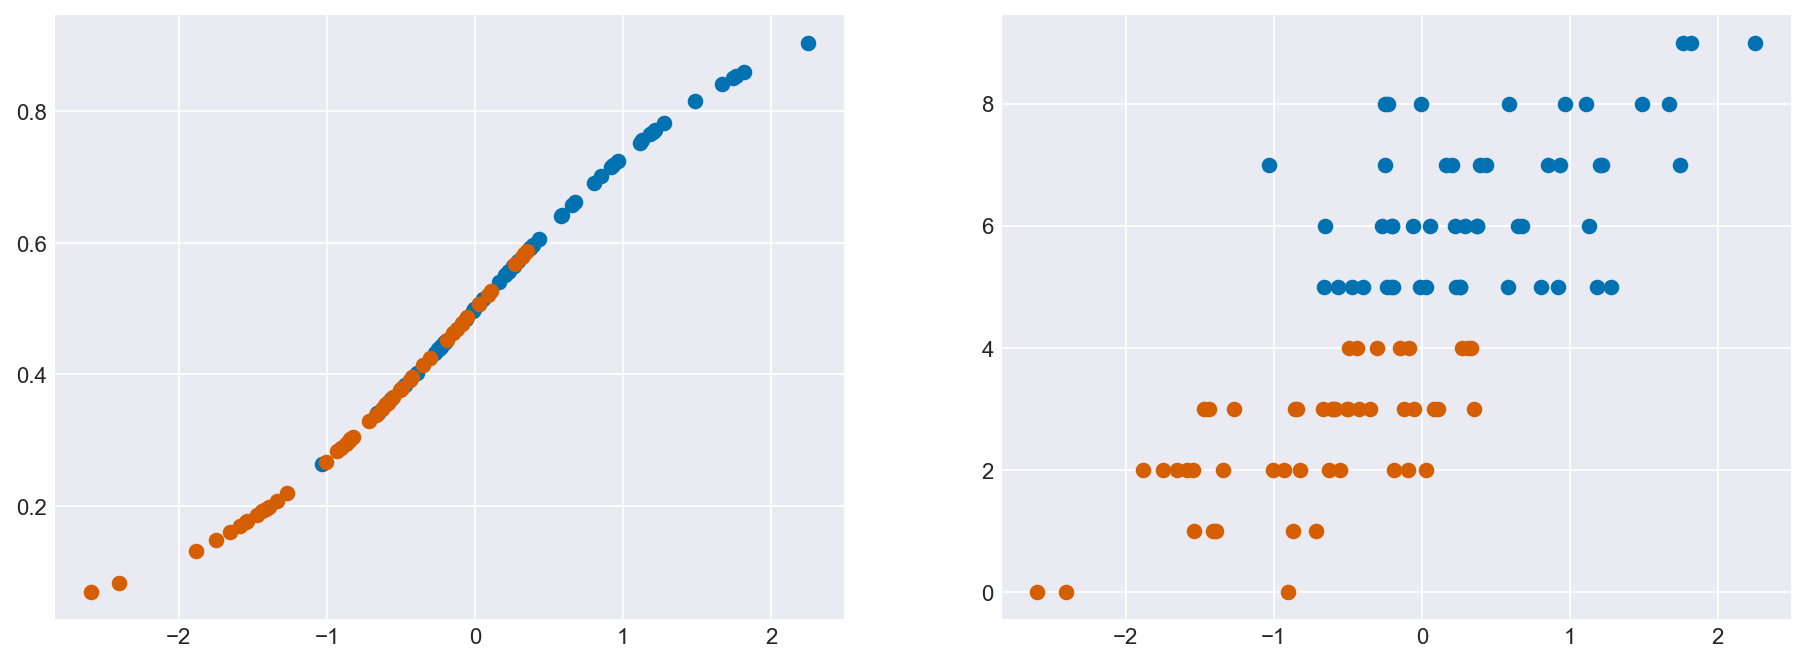

In [34]:
np.random.seed(45)
N = 100
S = np.random.normal(0, 1, size=N)
p = utils.sigmoid(S)
H = np.random.binomial(n=10, p=p, size=N).astype(float)
eat = (H < 5).astype(int)

raw_h = H.copy()
H[eat == 1] = float("nan")

plt.figure(figsize=(14,5), dpi=80)
plt.subplot(1,2,1)
plt.scatter(S[eat != 1], p[eat != 1])
plt.scatter(S[eat == 1], p[eat == 1], c="C2")

plt.subplot(1, 2, 2)
plt.scatter(S[eat != 1], raw_h[eat != 1])
plt.scatter(S[eat == 1], raw_h[eat == 1], c="C2")

In [35]:
with pm.Model() as model4:
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    p = pm.Deterministic("p", at.sigmoid(a + b * S[eat == 0]))

    h = pm.Binomial("h", n=10, p=p, observed=H[eat == 0])
    trace4 = pm.sample()
    
az.summary(trace4, var_names=["a", "b"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.413,0.101,0.218,0.593,0.002,0.001,2647.0,2632.0,1.0
b,0.364,0.123,0.127,0.582,0.002,0.002,2942.0,2781.0,1.0


In [36]:
with pm.Model() as model4:
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    p = pm.Deterministic("p", at.sigmoid(a + b * S))

    h = pm.Binomial("h", n=10, p=p, observed=H)
    trace4 = pm.sample()
    
az.summary(trace4, var_names=["a", "b"])

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/pymc/model.py:1431: ImputationWarning: Data in h contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, b]
>Metropolis: [h_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.397,0.110,0.186,0.597,0.008,0.006,172.0,514.0,1.03
b,0.374,0.132,0.115,0.609,0.010,0.007,158.0,480.0,1.04


# 15H1

In [238]:
df = pd.read_csv("data/elephants.csv", sep=";")


,AGE,MATINGS
AGE,1.000000,0.585693
MATINGS,0.585693,1.000000


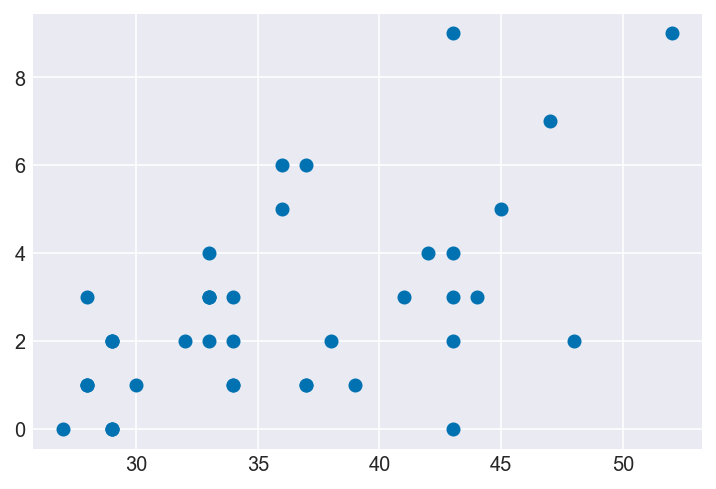

In [239]:
plt.scatter(df.AGE, df.MATINGS)
df.corr()

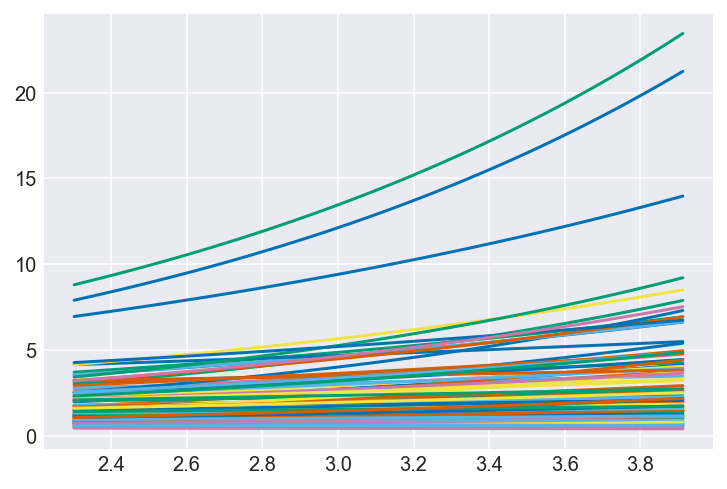

In [240]:
age_scaler = StandardScaler()
age_sd = age_scaler.fit_transform(df.AGE.values.reshape(-1, 1)).reshape(-1)
matings = df.MATINGS

N = 100
a = np.random.normal(0, .5, size=N)
b = np.random.normal(.2, .2, size=N)
for i in range(N):
    age = np.linspace(10, 50, num=N)
    x = np.log(age)
    y = np.exp(a[i] + b[i] * x)
    plt.plot(x, y)

In [241]:
with pm.Model() as model_15h1_1:
    a = pm.Normal("a", 0, .1)
    b = pm.Normal("b", .5, .2)
    mu = pm.Deterministic("mu", at.exp(a + b * np.log(df.AGE)))
    _matings = pm.Poisson("matings", mu=mu, observed=matings)
    trace_15h1_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [242]:
az.summary(trace_15h1_1, var_names=["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.041,0.098,-0.207,0.153,0.003,0.002,1295.0,1986.0,1.01
b,0.297,0.037,0.227,0.365,0.001,0.001,1364.0,1638.0,1.00


In [254]:
with pm.Model() as model_15h1_2:
    a = pm.Normal("a", 0, .5)
    b = pm.Normal("b", .2, .2)
    age = pm.Normal("age", mu=0, sigma=1, shape=len(age_sd))
    age_obs = pm.Normal("age_obs", age, 5/np.std(df.AGE), observed=age_sd)

    mu = pm.Deterministic("mu", at.exp(a + b * age))
    _matings = pm.Poisson("matings", mu=mu, observed=matings)
    trace_15h1_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [255]:
az.summary(trace_15h1_2, var_names=["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.826,0.117,0.617,1.058,0.002,0.001,4882.0,3196.0,1.0
b,0.526,0.110,0.331,0.742,0.002,0.001,3213.0,2836.0,1.0


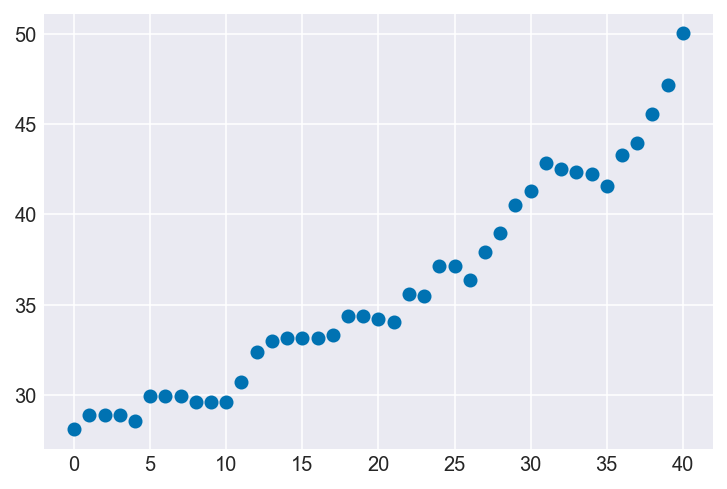

In [257]:
# plt.scatter(df.AGE, df.MATINGS)
corrected_matings = trace_15h1_2["posterior"]["age"].mean(axis=(0,1))
plt.scatter(range(len(df)), df.AGE - corrected_matings)

In [258]:
with model_15h1_2:
    posterior = pm.sample_posterior_predictive(trace_15h1_2)

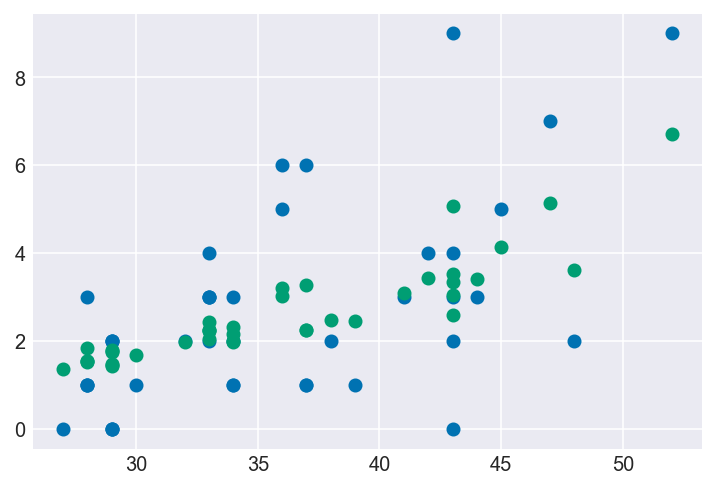

In [259]:
plt.scatter(df.AGE, df.MATINGS)
x = trace_15h1_2["posterior"]["age"].mean(axis=(0,1))
x = age_scaler.inverse_transform(x.values.reshape(-1, 1))[..., 0]
y = posterior.posterior_predictive["matings"].mean(axis=(0,1))
plt.scatter(df.AGE, y)

# 15H3

In [118]:
np.random.seed(100)
x = np.concatenate([np.random.normal(0, 1, size=10), [float("nan")]])
y = np.concatenate([np.random.normal(x[:10], 1, size=10), [100.]])

In [128]:
with pm.Model() as model_15h3:
    sigma = pm.Exponential("sigma", lam=1)
    beta = pm.Normal("beta", mu=0, sigma=100)
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    x_ = pm.Normal("x", mu=0, sigma=1, observed=x)
    mu = alpha + beta * x_
    y_ = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace_15h3 = pm.sample()

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/pymc/model.py:1431: ImputationWarning: Data in x contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, x_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9674, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029, but should be close to 0.8. Try to increase the number of tuning steps.


In [129]:
az.summary(trace_15h3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,5.278,16.572,-21.058,23.515,6.752,5.027,9.0,65.0,1.37
alpha,3.498,4.597,-4.994,11.986,0.153,0.115,907.0,1233.0,1.01
x_missing[0],1.079,3.414,-4.466,4.976,1.355,1.006,10.0,184.0,1.33
sigma,13.397,2.504,9.128,18.074,0.123,0.087,386.0,596.0,1.02


<AxesSubplot:title={'center':'beta'}>

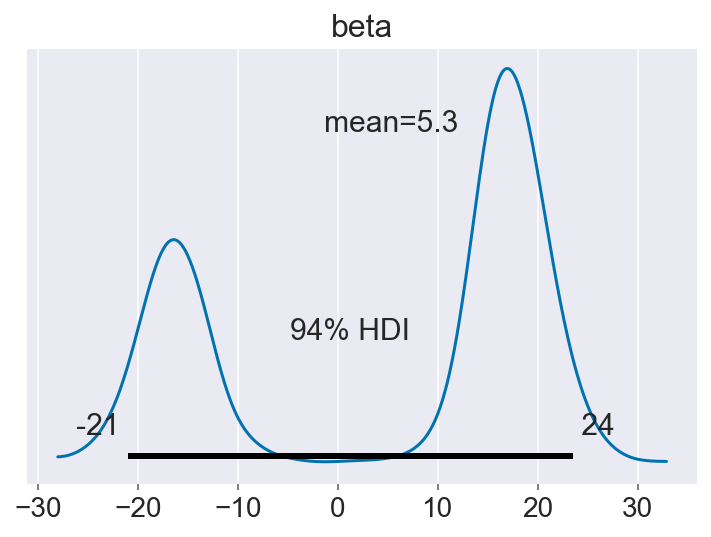

In [130]:
az.plot_posterior(trace_15h3, var_names=["beta"])

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'x_missing'}>,
        <AxesSubplot:title={'center':'x_missing'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

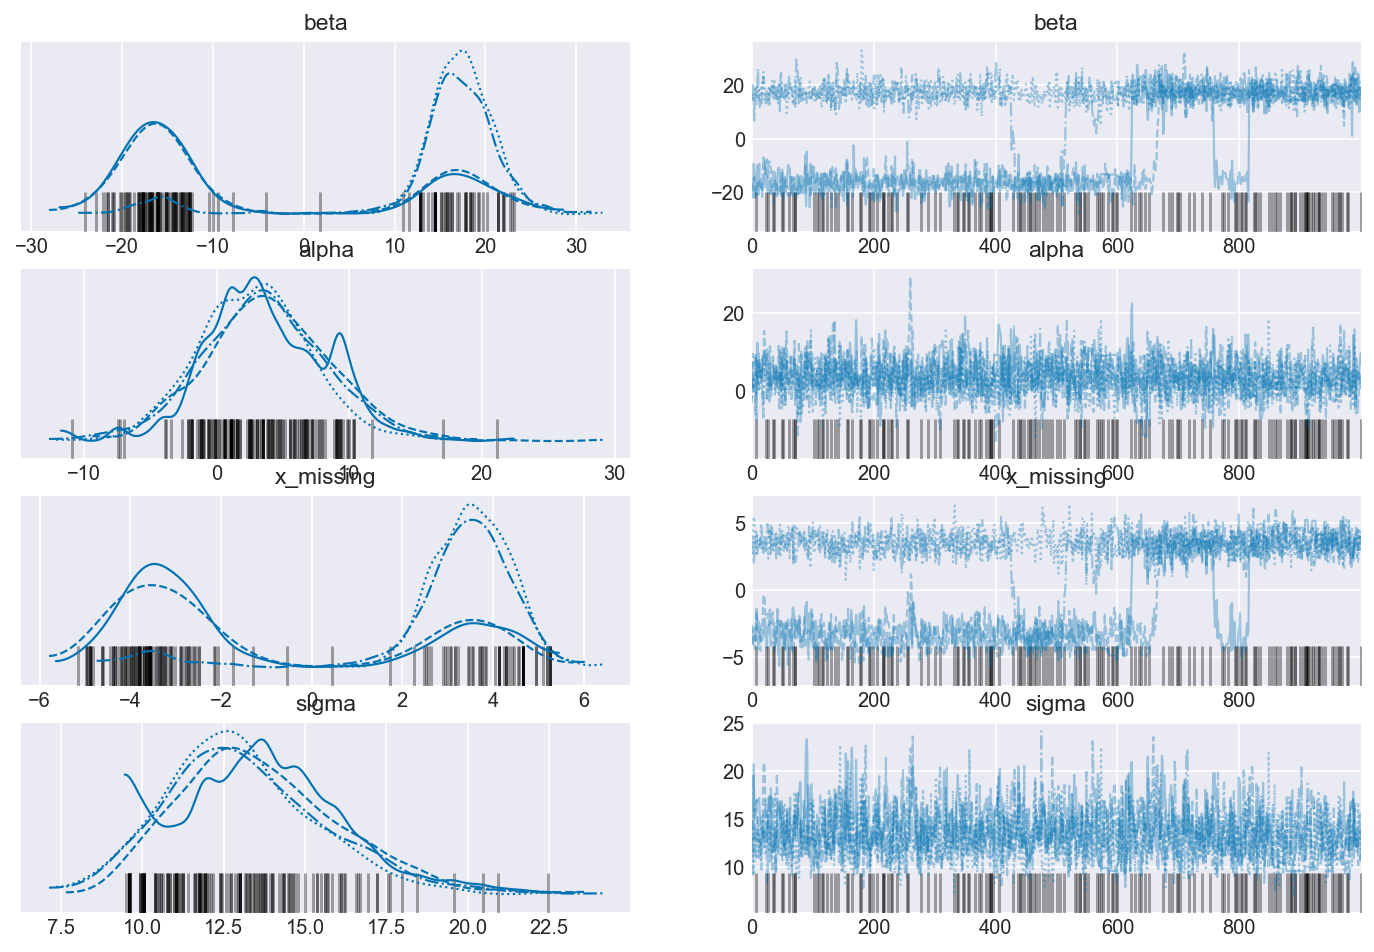

In [131]:
az.plot_trace(trace_15h3)

# 15H4

In [132]:
df = pd.read_csv("data/Primates301.csv", sep=";")

In [133]:
df.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [181]:
df = df[["brain", "body"]].dropna()
df = df.transform(lambda x: x/x.max())
B = df.brain
M = df.body
Bse = B*0.1
Mse = M*0.1

In [183]:
with pm.Model() as model_15h4:
    sigma = pm.Exponential("sigma", lam=1)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)

    mu = alpha + beta * np.log(M)
    brain = pm.LogNormal("B", mu=mu, sigma=sigma, observed=B)

    trace_15h4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [191]:
az.summary(trace_15h4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.428,0.060,0.316,0.540,0.002,0.001,1431.0,1667.0,1.0
beta,0.783,0.015,0.754,0.809,0.000,0.000,1441.0,1426.0,1.0
sigma,0.293,0.016,0.264,0.323,0.000,0.000,2227.0,2015.0,1.0


In [230]:
with pm.Model() as model_15h4_2:
    sigma = pm.Exponential("sigma", lam=1)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)

    Mtrue = pm.Beta("Mtrue", alpha=2, beta=2, shape=len(M))
    Mobs = pm.Normal("Mobs", mu=Mtrue, sigma=Mse, observed=M)
    # Mtrue = pm.Normal("Mtrue", mu=0.5, sigma=0.1, shape=len(M))
    # Mobs = pm.Normal("Mobs", mu=Mtrue, sigma=Mse, observed=M)

    mu = alpha + beta * at.log(Mtrue)

    brain = pm.LogNormal("B", mu=mu, sigma=sigma)
    Bobs = pm.Normal("brain", mu=brain, sigma=Bse, observed=B)

    trace_15h4_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta, Mtrue, B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [231]:
az.summary(trace_15h4_2, var_names=["alpha", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.417,0.058,0.310,0.527,0.001,0.001,4888.0,2916.0,1.0
beta,0.785,0.014,0.761,0.814,0.000,0.000,4738.0,2732.0,1.0
sigma,0.262,0.017,0.228,0.292,0.000,0.000,4506.0,2839.0,1.0


In [262]:
with model_15h4_2:
    posterior = pm.sample_posterior_predictive(trace_15h4_2)

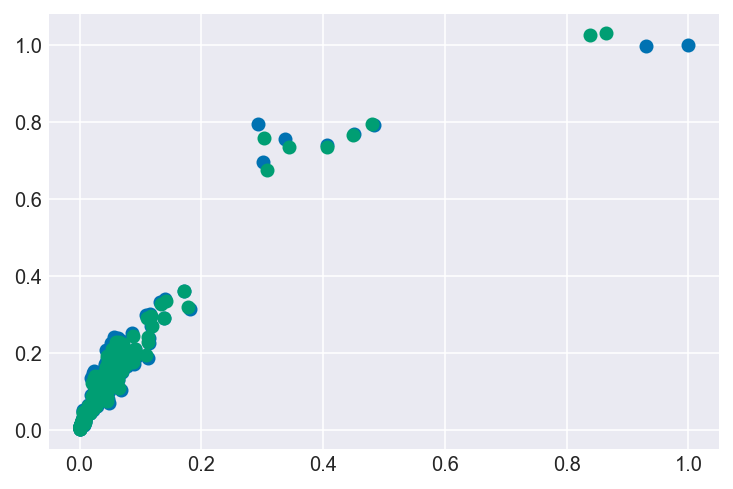

In [267]:
y_hat = trace_15h4_2.posterior["B"].mean(axis=(0,1))
x_hat = trace_15h4_2.posterior["Mtrue"].mean(axis=(0,1))
plt.scatter(M, B)
plt.scatter(x_hat, y_hat)

# 15H5

In [270]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [273]:
df = pd.read_csv("data/marriage.csv", sep=";")

D_obs = StandardScaler().fit_transform(df.Divorce.values.reshape(-1, 1)).reshape(-1)
D_sd = df["Divorce SE"] / np.std(df["Divorce"])
M = StandardScaler().fit_transform(df.Marriage.values.reshape(-1, 1)).reshape(-1)
M_sd = df["Marriage SE"] / np.std(df["Divorce"])
A = StandardScaler().fit_transform(df.MedianAgeMarriage.values.reshape(-1, 1)).reshape(-1)
N = len(df)

with pm.Model() as model_15h5:
    betaA = pm.Normal("betaA", 0, 0.5)
    alphaA = pm.Normal("alphaA", 0, 0.2)
    sigmaM = pm.Exponential("sigmaM", lam=1)
    Mtrue = pm.Normal("Mtrue", mu=alphaA + betaA * A, sigma=sigmaM)
    Mobs = pm.Normal("Mobs", mu=Mtrue, sigma=M_sd, observed=M)

    sigma = pm.Exponential("sigma", lam=1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * A + bM * Mtrue)

    d_true = pm.Normal("d_true", mu=mu, sigma=sigma)
    d_obs = pm.Normal("d_obs", mu=d_true, sigma=D_sd, observed=D_obs)

    trace_15h5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaA, alphaA, sigmaM, Mtrue, sigma, bA, bM, a, d_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [274]:
az.summary(trace_15h5, var_names=["a", "bA", "bM", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.110,-0.206,0.203,0.003,0.002,1614.0,2383.0,1.00
bA,-0.394,0.248,-0.851,0.077,0.008,0.006,923.0,1853.0,1.00
bM,0.451,0.380,-0.252,1.163,0.014,0.010,758.0,1360.0,1.00
sigma,0.558,0.122,0.328,0.790,0.006,0.004,385.0,502.0,1.01


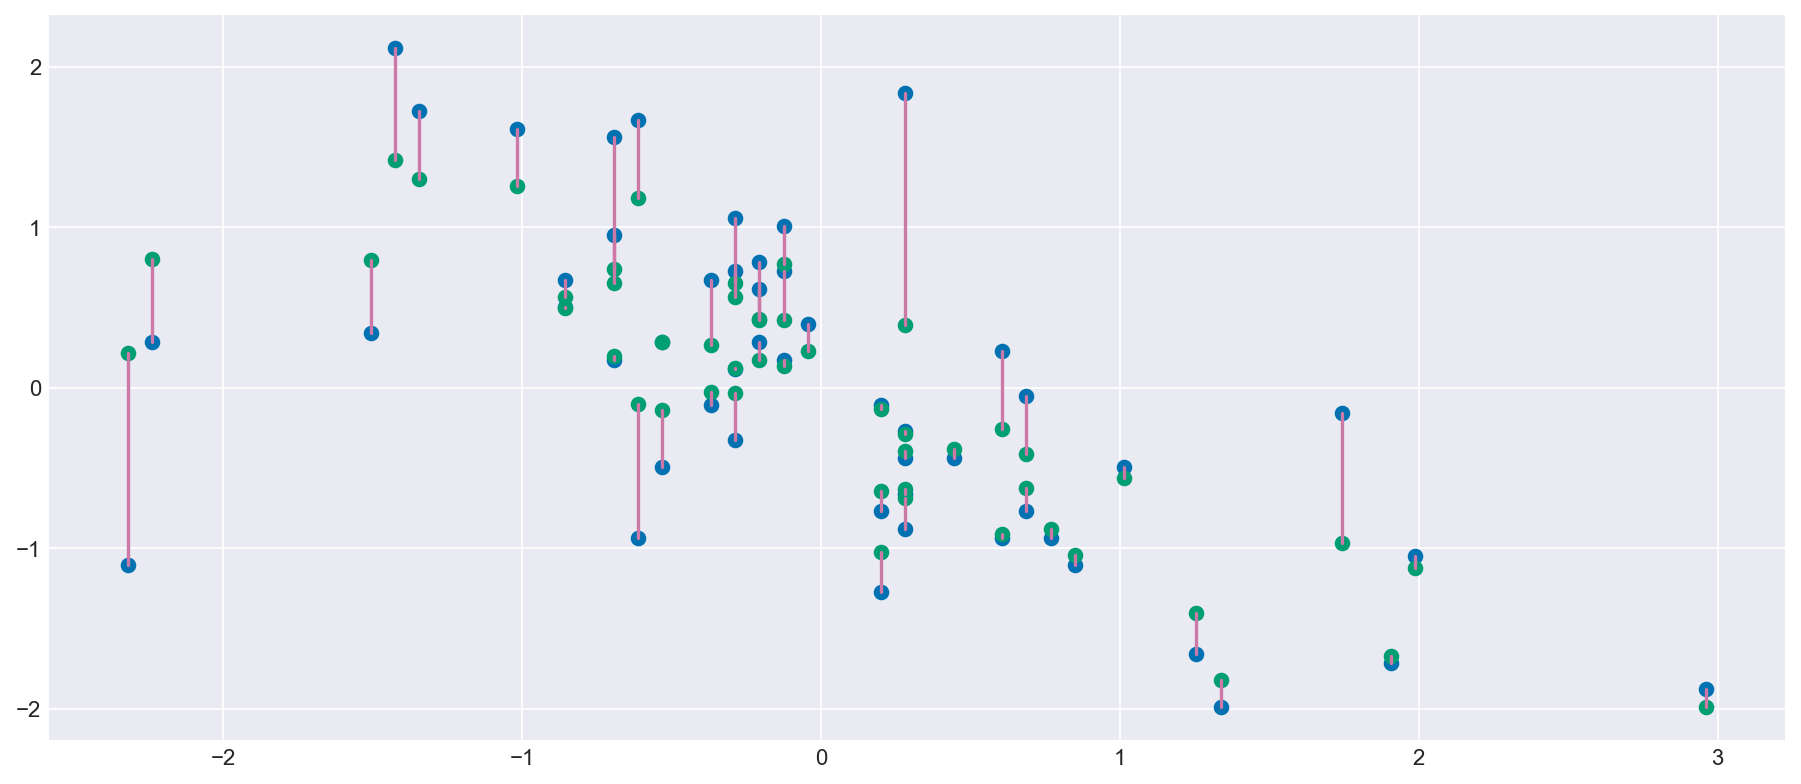

In [275]:
plt.figure(figsize=(14,6), dpi=80)

d_true = trace_15h5["posterior"]["d_true"].mean(axis=(0,1)).values.reshape(-1)
plt.scatter(A, D_obs)
plt.scatter(A, d_true)

for a,b,c in zip(A, D_obs, d_true):
    plt.plot([a, a], [b, c], c="C3")

array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'bA'}>,
       <AxesSubplot:title={'center':'bM'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

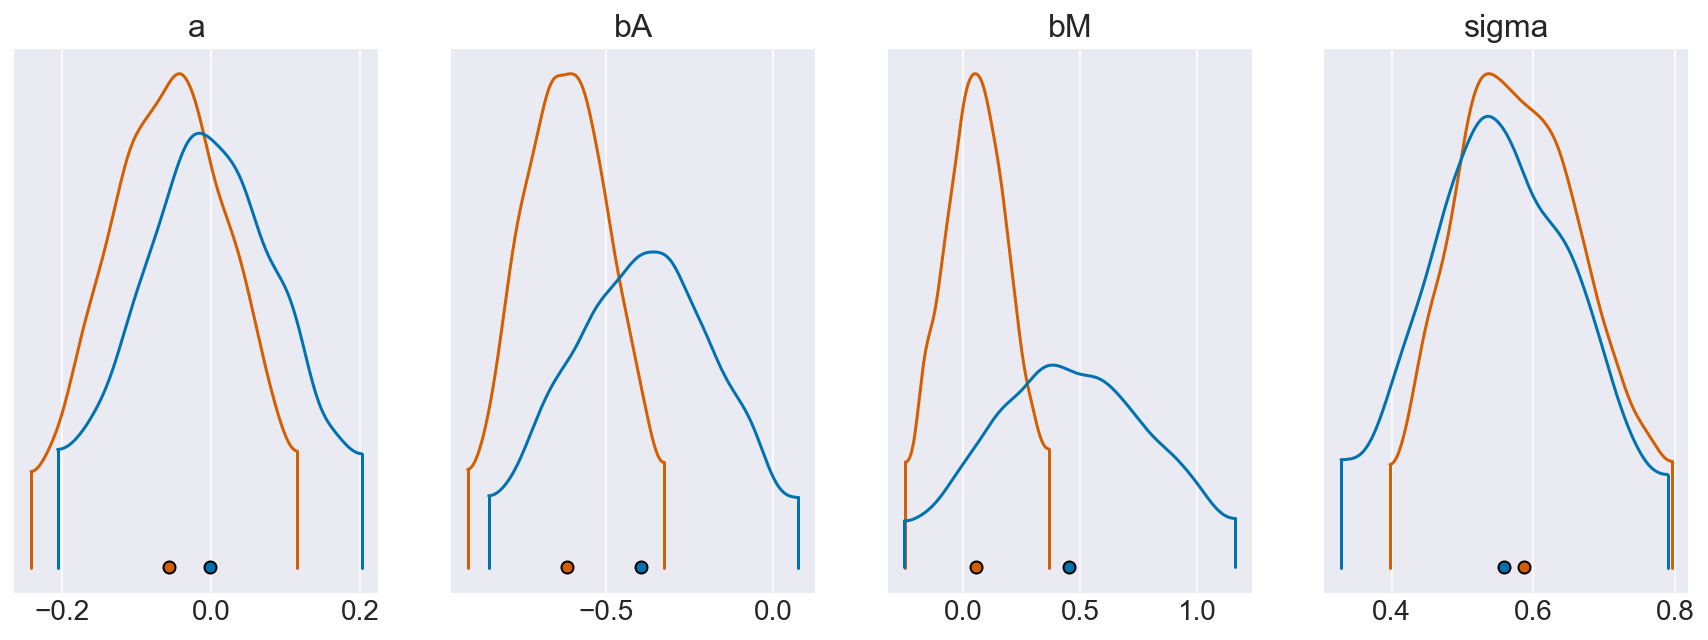

In [290]:
fig, axes = plt.subplots(1, 4)
fig.set_figheight(5)
fig.set_figwidth(15)
az.plot_density(trace3, var_names=["a", "bA", "bM", "sigma"], ax=axes, colors="C2")
az.plot_density(trace_15h5, var_names=["a", "bA", "bM", "sigma"], ax=axes)

# 15H7

Some lad named Andrew made an eight-sided spinner. He wanted to know if it is fair. So he spun it a bunch of times, recording the counts of each value. Then the accidentally spiller cofee over the 4s and 5s. The surviving data are summarized below.

| Value | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
|--|--|--|--|--|--|--|--|--|
| Frequency | 18 | 19 | 22 | NA | NA | 19 | 20 | 22 |

Your job is to **impute the two missing values** in the table above. Andrew doesn't remember how many times he spun the spinner. So you will have to **assign a prior distribution for the total number of spins** and **then marginalize over the unknown total**. Andrew is not sure the spinner is fair (every value is equally likely), but he's confident that **none of the values is twice as likely as any other. Use a Dirichlet distribution to capture this prior belief**. Plot the join posterior distribution of the 4s and 5s.

In [19]:
y = np.array([18, 19, 22, np.nan, np.nan, 19, 20, 22])
y_, y_sum = y[~np.isnan(y)].mean(), y[~np.isnan(y)].sum()
y_, y_sum

(20.0, 120.0)

P(a4,a5|N) = P(N|a4=0,a5=0) * P(a4=0,a5=0)/P(N) + ...
             P(N|a4=1,a5=0) * P(a4=1,a5=0)/P(N)

prior = D()
P(a4,a5|40)*P()